In [1]:
!pip install seaborn

In [2]:
!pip install tsai

  Obtaining dependency information for tsai from https://files.pythonhosted.org/packages/0c/05/44204ea197bf872279f1d445139283b8d30983fa04d177dc12728a0c7ba8/tsai-0.3.8-py3-none-any.whl.metadata
  Obtaining dependency information for pyts>=0.12.0 from https://files.pythonhosted.org/packages/b3/e3/da2042a20782b105631abe273ca5fef4390e7bdb6f5377c596891262437b/pyts-0.13.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.2/324.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 61.8 MB/s eta 0:00:00:00:01


In [3]:
!pip install adtk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00


In [4]:
!pip install sktime

  Obtaining dependency information for sktime from https://files.pythonhosted.org/packages/e5/81/1141e6eb5a43310f39981d1c61abea9a03a0ecb9d62685cc537fa34786c8/sktime-0.25.0-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-base<0.7.0 from https://files.pythonhosted.org/packages/14/5f/99cfea6a41a806499f8041dbaf183f0e147fa0a1e51a50a38f195a03b6ef/scikit_base-0.6.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 57.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 10.7 MB/s eta 0:00:00


In [5]:
!pip install statsmodels

In [6]:
!pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.7 MB/s eta 0:00:00a 0:00:01


In [7]:
import warnings
import sktime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pmdarima as pm
import statsmodels.api as sm

from adtk.detector import QuantileAD, SeasonalAD
from sklearn.model_selection import train_test_split
from sktime.datatypes import convert_to
from sklearn.cluster import DBSCAN, KMeans
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.tbats import TBATS
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima import AutoARIMA

from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sktime.classification.interval_based import (TimeSeriesForestClassifier, 
                                                  RandomIntervalSpectralEnsemble, 
                                                  SupervisedTimeSeriesForest)
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn.neighbors import KNeighborsClassifier
from tsai.all import *
from IPython.display import clear_output
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
sns.set_style('white')
sns.set(rc={'figure.figsize': (11, 4)})

## 1.

In [9]:
# dummy dataset
DF_ORIG = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv', index_col='timestamp', parse_dates=True)
#DF_ORIG = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_IBM.csv', index_col='timestamp', parse_dates=True)

In [10]:
DF_ORIG.head()

,value
timestamp,
2015-02-26 21:42:53,57
2015-02-26 21:47:53,43
2015-02-26 21:52:53,55
2015-02-26 21:57:53,64
2015-02-26 22:02:53,93


In [11]:
DF_ORIG.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15831 entries, 2015-02-26 21:42:53 to 2015-04-22 20:52:53
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   15831 non-null  int64
dtypes: int64(1)
memory usage: 247.4 KB


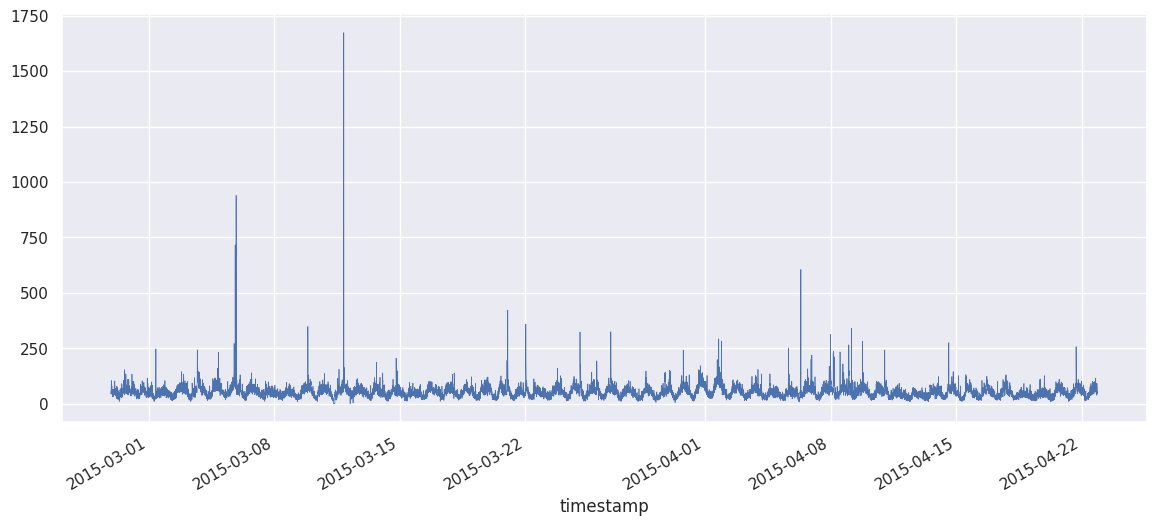

In [12]:
plt.figure(figsize=(14, 6))
DF_ORIG['value'].plot(linewidth=0.5)
plt.show()

In [13]:
DF_ORIG['date'] = pd.to_datetime(DF_ORIG.index).date

In [14]:
DF_ORIG['h'] = pd.to_datetime(DF_ORIG.index).hour

In [15]:
DF_ORIG.head(1)

,value,date,h
timestamp,,,
2015-02-26 21:42:53,57,2015-02-26,21


In [16]:
df_date = DF_ORIG.groupby('date').sum()

### TODO: chance that i must drop outliers

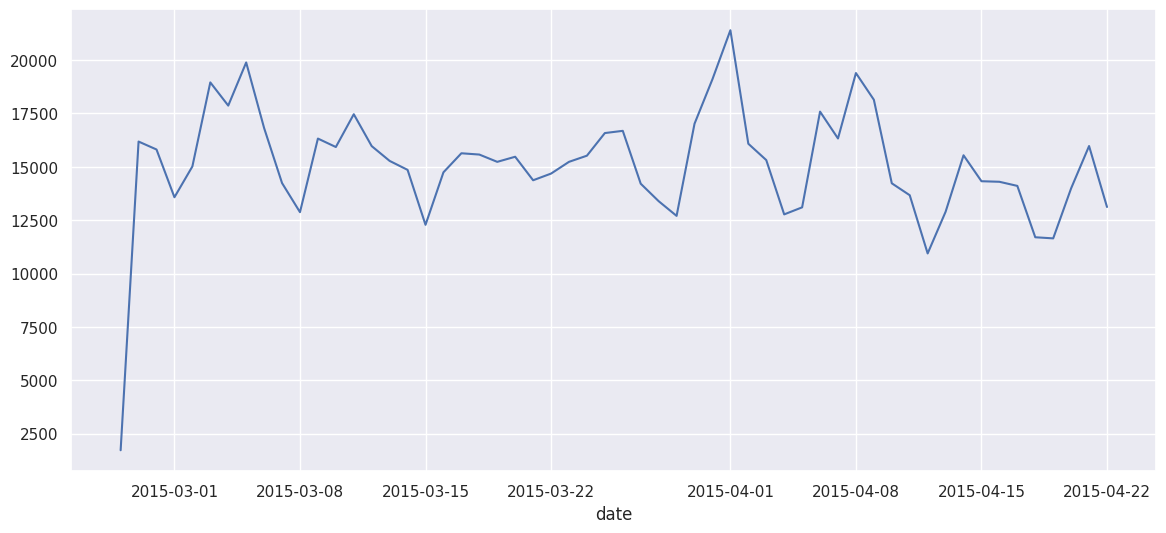

In [17]:
plt.figure(figsize=(14, 6))
df_date['value'].plot()
plt.show()

In [18]:
df_h = DF_ORIG.groupby(pd.Grouper(freq='1h')).sum(numeric_only=True)
df_h.head(5)

,value,h
timestamp,,
2015-02-26 21:00:00,219,84
2015-02-26 22:00:00,931,264
2015-02-26 23:00:00,568,276
2015-02-27 00:00:00,516,0
2015-02-27 01:00:00,574,12


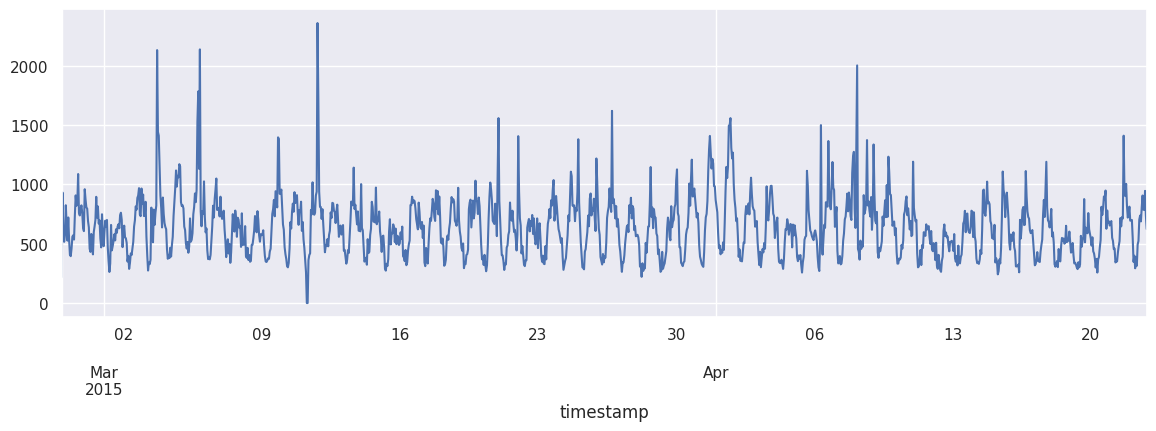

In [19]:
plt.figure(figsize=(14, 4))
df_h['value'].plot()
plt.show()

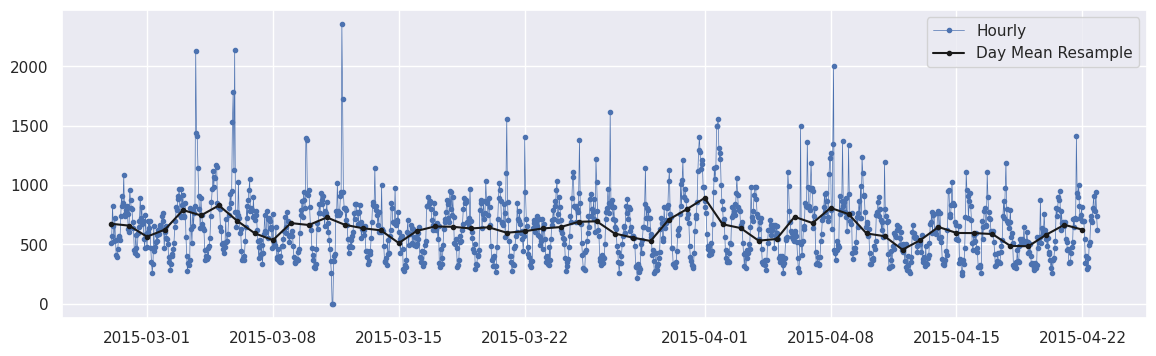

In [20]:
start, end = '2015-02-27', '2015-04-22'

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_h.loc[start:end, 'value'],marker='.', linestyle='-', linewidth=0.5, label='Hourly')
ax.plot(df_h.resample('D').mean().loc[start:end, 'value'], marker='o',
        markersize=3, linestyle='-', label='Day Mean Resample', color='k')
ax.legend();

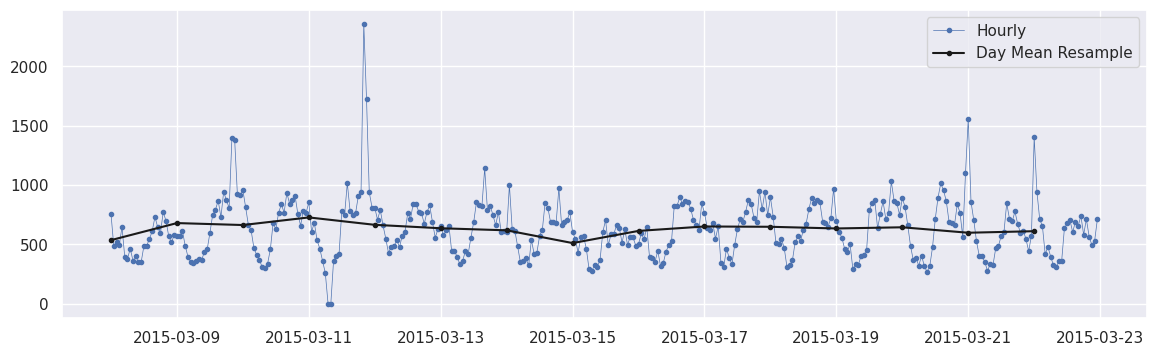

In [21]:
start, end = '2015-03-08', '2015-03-22'

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_h.loc[start:end, 'value'],marker='.', linestyle='-', linewidth=0.5, label='Hourly')
ax.plot(df_h.resample('D').mean().loc[start:end, 'value'], marker='o', markersize=3, linestyle='-', label='Day Mean Resample', color='k')
ax.legend();

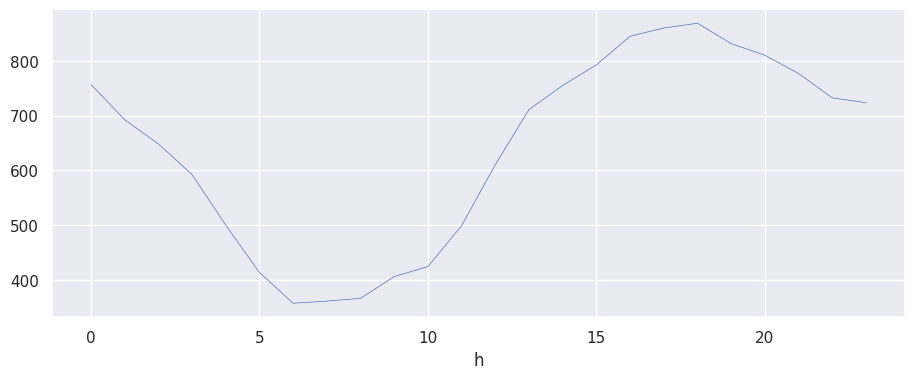

In [22]:
df_h.h = pd.to_datetime(df_h.index).hour

df_h_h = df_h.groupby('h').mean()

df_h_h['value'].plot(linewidth=0.5)
plt.show()

## 2.

### TODO: simplify imports

In [23]:
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))

smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

%matplotlib inline

In [24]:
df_h_copy = df_h.value.astype('float')

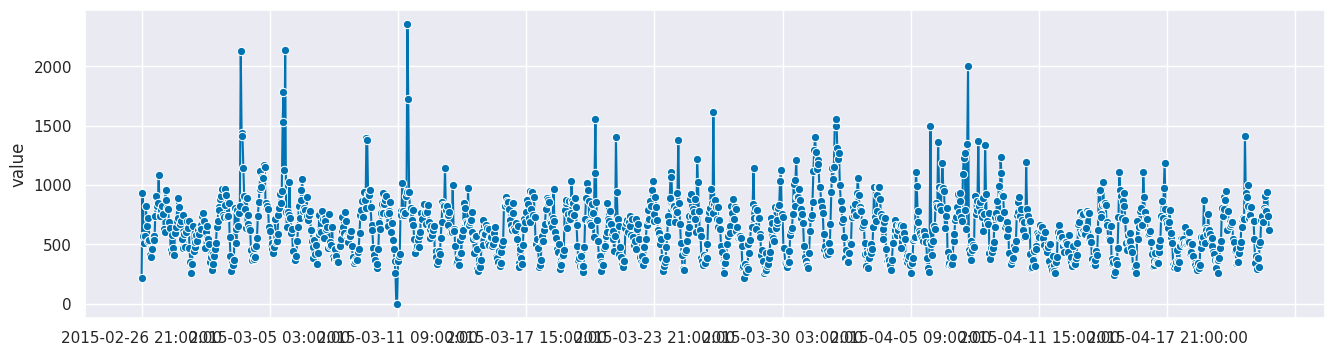

In [25]:
sktime.utils.plotting.plot_series(df_h_copy)
plt.show()

In [26]:
X_train, X_test = temporal_train_test_split(df_h_copy, test_size=int(df_h_copy.size * 0.3))

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

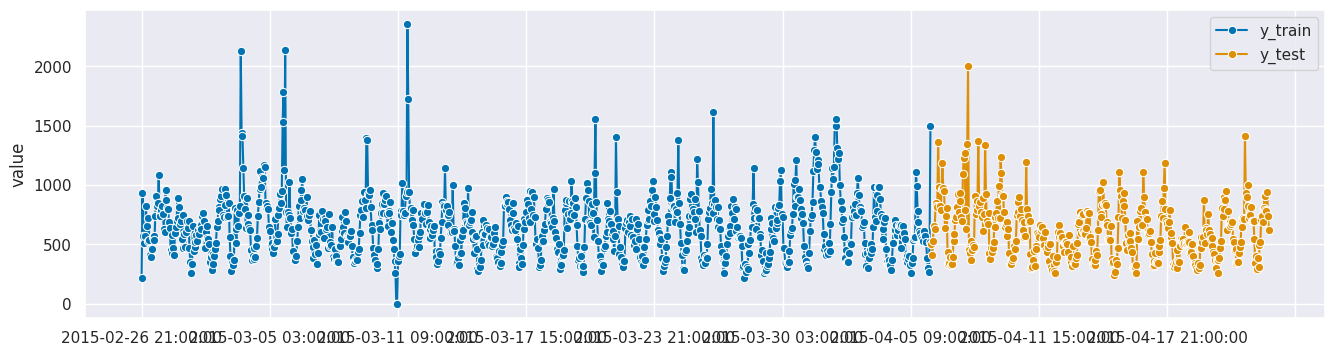

In [27]:
sktime.utils.plotting.plot_series(X_train, X_test, labels=['y_train', 'y_test'])

### TODO: change these values

In [28]:
for i in range(len(X_train)):
    if X_train[i] > 1400:
        X_train[i] = 1400
    if X_train[i] < 250:
        X_train[i] = 250

In [29]:
FH = ForecastingHorizon(X_test.index, is_relative=False)

In [30]:
FORECASTER = NaiveForecaster(strategy="mean", sp=24)

In [31]:
FORECASTER.fit(X_train)

NaiveForecaster(sp=24, strategy='mean')

In [32]:
X_pred = FORECASTER.predict(FH)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

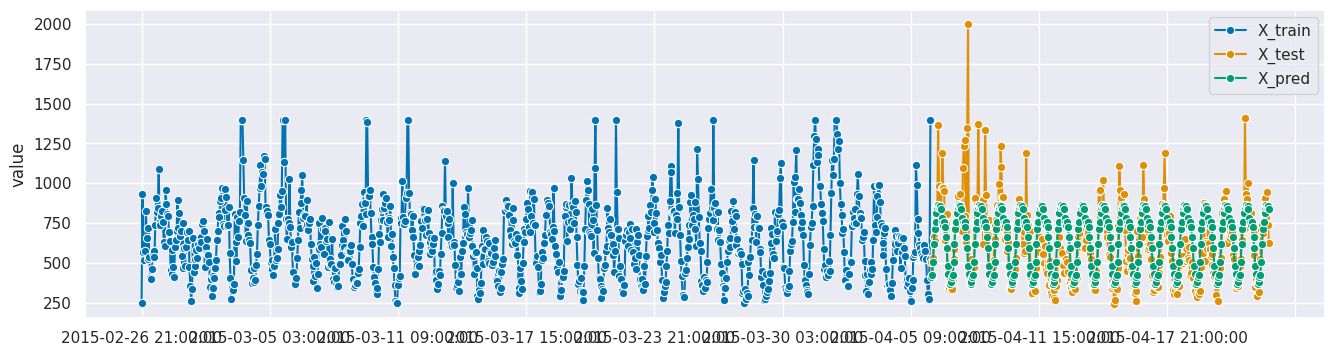

In [33]:
plot_series(X_train, X_test, X_pred, labels=["X_train", "X_test", "X_pred"])

In [34]:
smape(X_pred.values, X_test.values)

0.1934016537943034

In [35]:
FORECASTER = NaiveForecaster(strategy="mean", sp=24 * 7)

In [36]:
FORECASTER.fit(X_train)

NaiveForecaster(sp=168, strategy='mean')

In [37]:
X_pred = FORECASTER.predict(FH)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

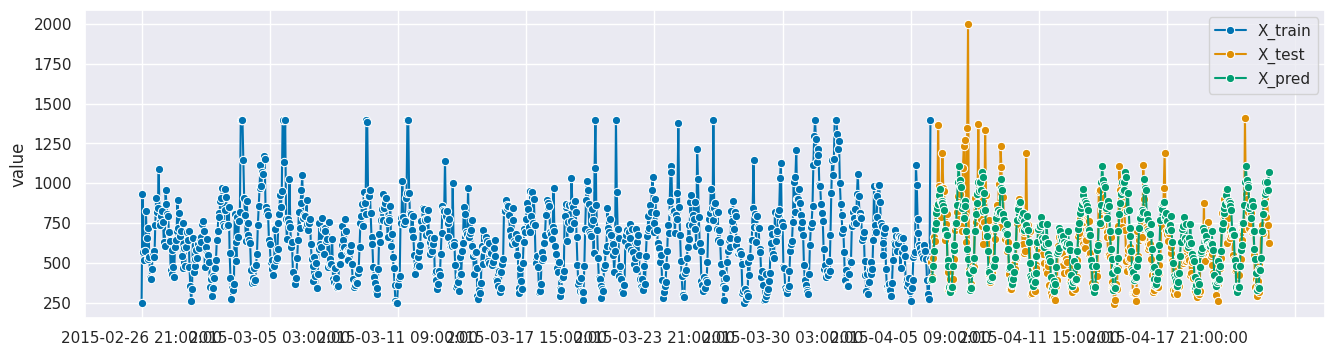

In [38]:
plot_series(X_train, X_test, X_pred, labels=["X_train", "X_test", "X_pred"])

In [39]:
smape(X_pred.values, X_test.values)

0.17805836797084076

In [40]:
FORECASTER = ThetaForecaster(sp=24 * 7)

In [41]:
FORECASTER.fit(X_train, fh=FH)

ThetaForecaster(sp=168)

In [42]:
X_pred = FORECASTER.predict(FH)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

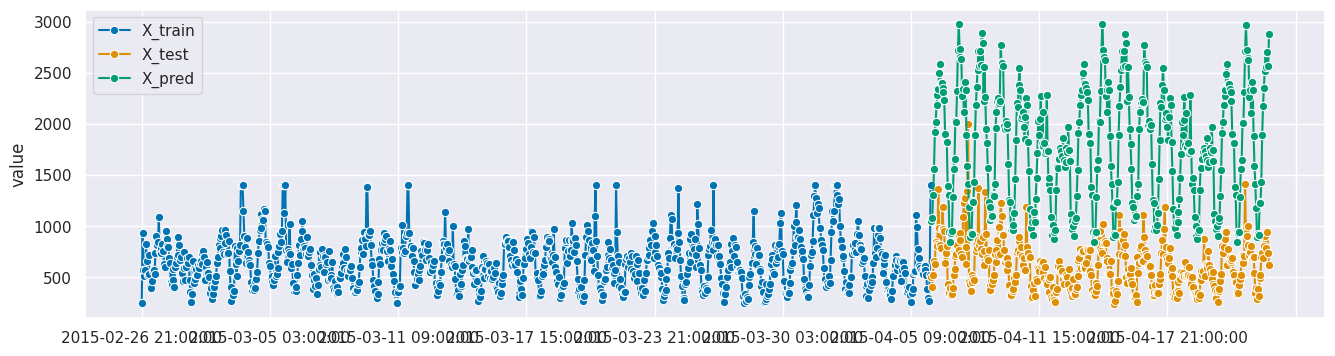

In [43]:
plot_series(X_train, X_test, X_pred, labels=["X_train", "X_test", "X_pred"])

In [44]:
smape(X_pred.values, X_test.values)

0.9846583011026532

In [45]:
FORECASTER = ExponentialSmoothing(trend="mul", seasonal="add", sp=24 * 7, method='ls')

In [46]:
FORECASTER.fit(X_train)

ExponentialSmoothing(method='ls', seasonal='add', sp=168, trend='mul')

In [47]:
y_pred = FORECASTER.predict(FH)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

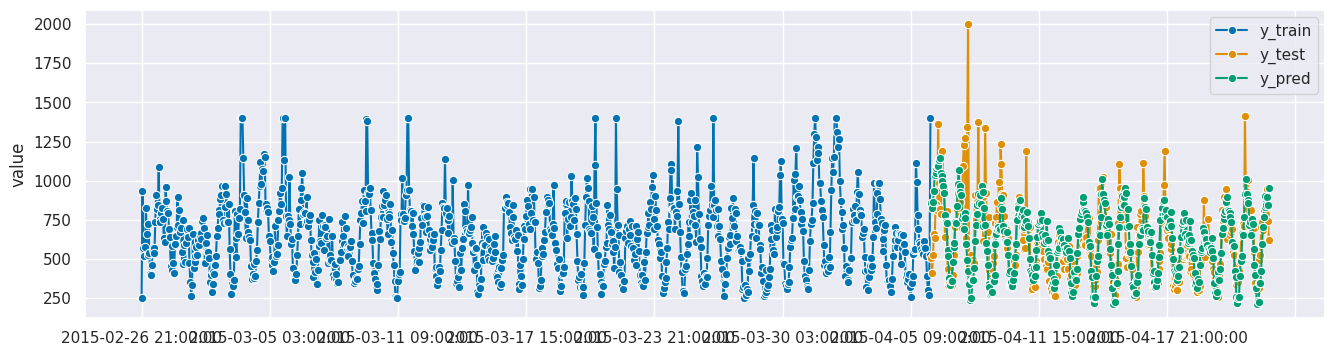

In [48]:
plot_series(X_train, X_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [49]:
smape(y_pred.values, X_test.values)

0.1899102308715659

In [50]:
ses = ExponentialSmoothing()

FORECASTER = TransformedTargetForecaster(
                steps=[
                ("deseasonalize1", Deseasonalizer(model="multiplicative", sp=24)),
                ("deseasonalize2", Deseasonalizer(model="multiplicative", sp=24*7)),
                ("forecaster", ses),
                ])
FORECASTER.fit(X_train)

TransformedTargetForecaster(steps=[('deseasonalize1',
                                    Deseasonalizer(model='multiplicative',
                                                   sp=24)),
                                   ('deseasonalize2',
                                    Deseasonalizer(model='multiplicative',
                                                   sp=168)),
                                   ('forecaster', ExponentialSmoothing())])

In [51]:
X_pred = FORECASTER.predict(FH)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

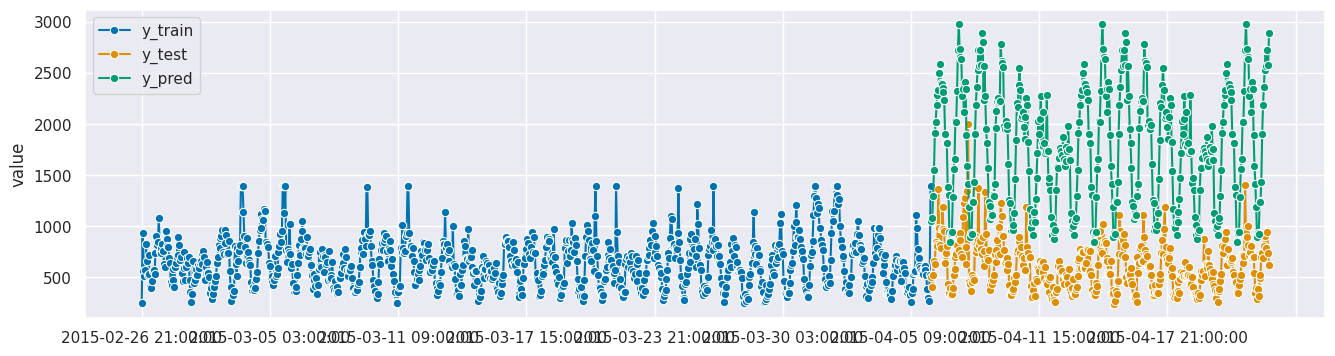

In [52]:
plot_series(X_train, X_test, X_pred, labels=["y_train", "y_test", "y_pred"])

In [53]:
smape(y_pred.values, X_test.values)

0.1899102308715659

## 3.

In [54]:
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)
r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))

In [55]:
ROLLING_MEAN = X_train.rolling(window = 24).mean()
ROLLING_STD  = X_train.rolling(window = 24).std()

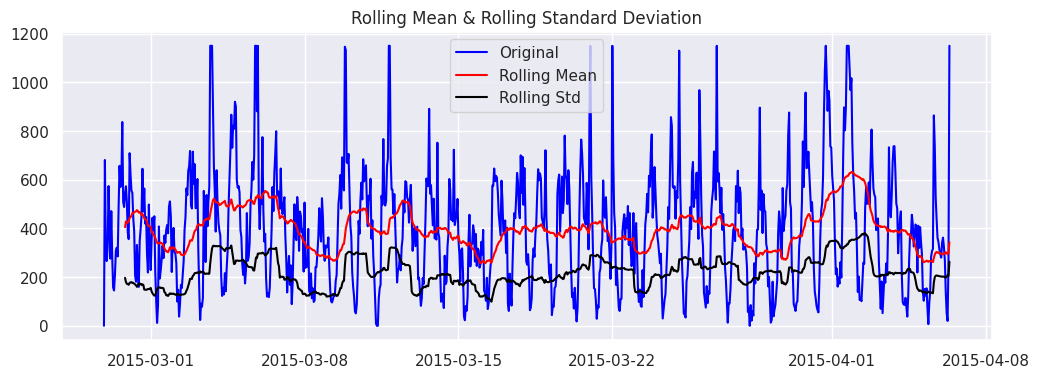

In [56]:
plt.figure(figsize=(12,4), dpi=100)

plt.plot(X_train - X_train[0],      color = 'blue',  label = 'Original')
plt.plot(ROLLING_MEAN - X_train[0], color = 'red',   label = 'Rolling Mean')
plt.plot(ROLLING_STD,             color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [57]:
P_THRESHOLD = 0.05

In [58]:
def check_ADF(y, p_threshold):
    result = adfuller(y)
    adf_value = result[0]
    p_value   = result[1]
    print('ADF Statistic: {:.4f}'.format(adf_value))
    print('p-value: {:.4f}'.format(p_value))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}, {}'.format(key, value, 'outperformed' if adf_value>value else ""))
    print(f'Result: The series is {"not " if p_value < p_threshold else ""}stationary')
    return result

In [59]:
check_ADF(X_train, P_THRESHOLD);

ADF Statistic: -3.4964
p-value: 0.0081
Critical Values:
	1%: -3.4376, 
	5%: -2.8647, 
	10%: -2.5685, 
Result: The series is not stationary


In [60]:
X_diff = X_train[:].diff(1).dropna()
rolling_mean = X_diff.rolling(window = 24).mean()
rolling_std  = X_diff.rolling(window = 24).std()

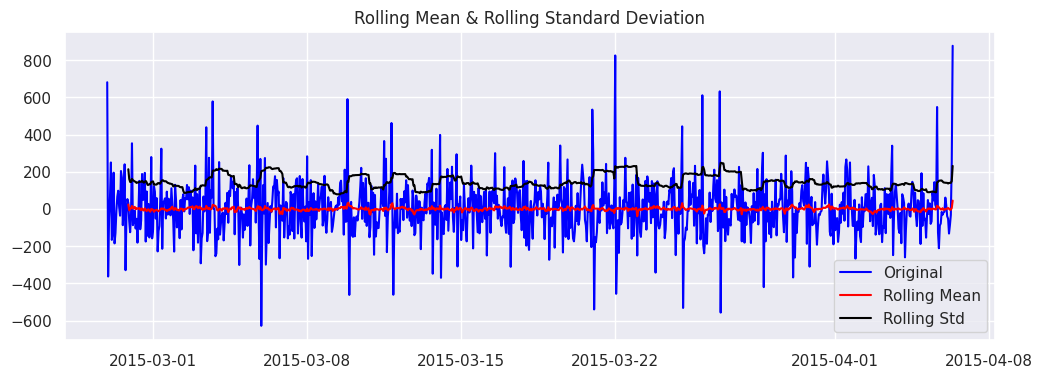

In [61]:
plt.figure(figsize=(12,4), dpi=100)

plt.plot(X_diff, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [62]:
result = check_ADF(X_diff, P_THRESHOLD)

ADF Statistic: -16.6319
p-value: 0.0000
Critical Values:
	1%: -3.4376, 
	5%: -2.8648, 
	10%: -2.5685, 
Result: The series is not stationary


In [63]:
SEASON = 24

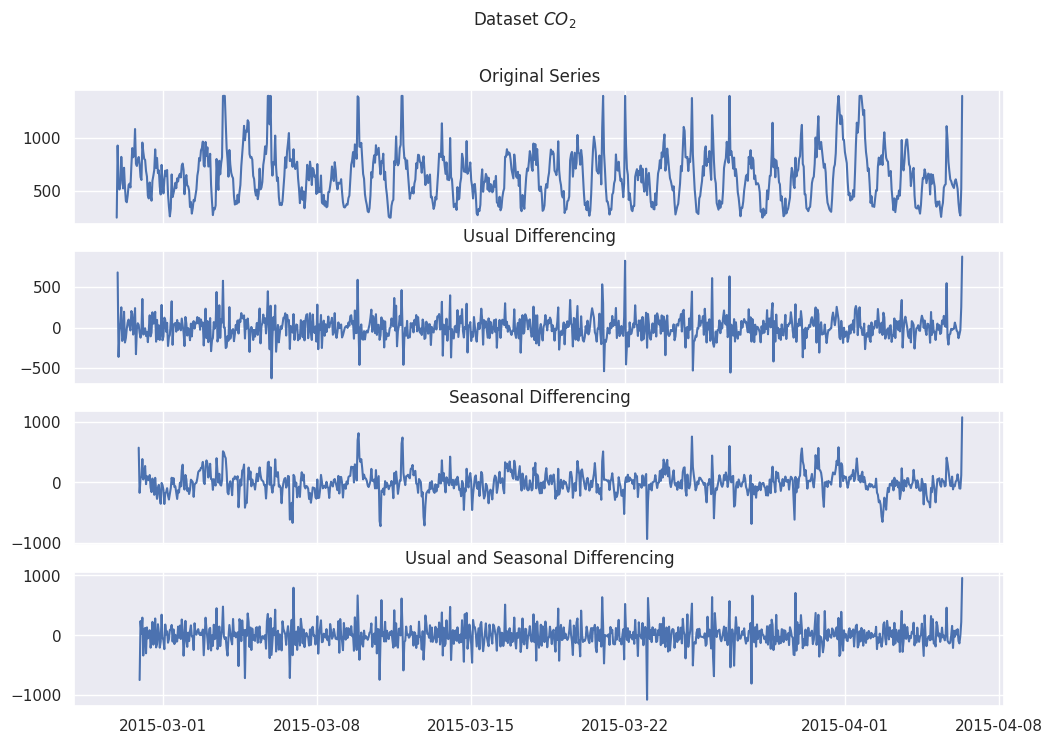

In [64]:
# Plot
fig, axes = plt.subplots(4, 1, figsize=(12,8), dpi=100, sharex=True)

# Original Series
axes[0].plot(X_train[:])
axes[0].set_title('Original Series')
# plt.show()

# Usual Differencing
axes[1].plot(X_train[:].diff(1))
axes[1].set_title('Usual Differencing')

# Seasinal Differencing
axes[2].plot(X_train[:].diff(SEASON))
axes[2].set_title('Seasonal Differencing')

# Seasinal and Usual Differencing
axes[3].plot(X_train[:].diff(1).diff(SEASON))
axes[3].set_title('Usual and Seasonal Differencing')

plt.suptitle('Dataset $CO_2$', fontsize=12)
plt.show()

In [65]:
X_sdif = X_train[:].diff(1).diff(SEASON).dropna()

In [66]:
results = check_ADF(X_sdif, P_THRESHOLD);

ADF Statistic: -7.9973
p-value: 0.0000
Critical Values:
	1%: -3.4378, 
	5%: -2.8648, 
	10%: -2.5685, 
Result: The series is not stationary


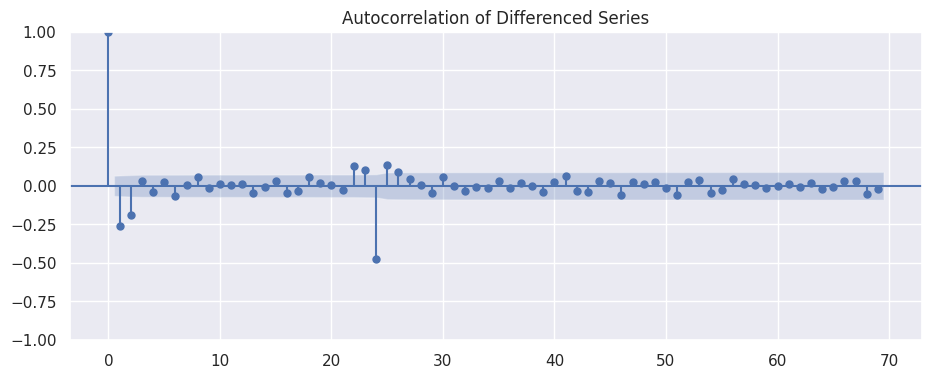

In [67]:
plot_acf(X_sdif, title='Autocorrelation of Differenced Series', lags=np.arange(70) )
plt.show()

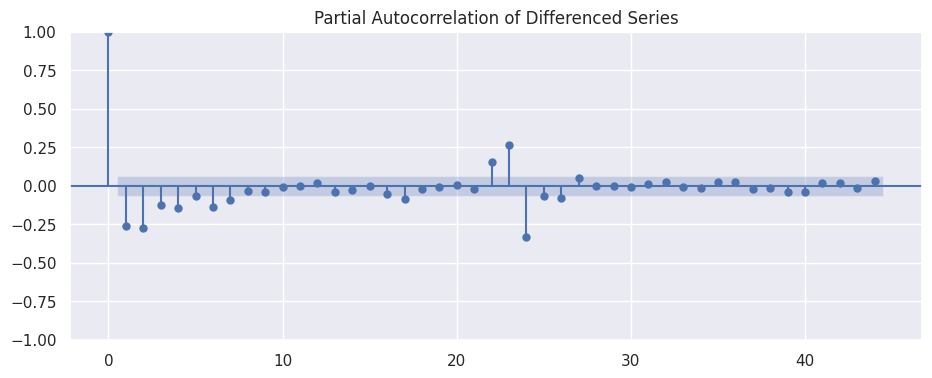

In [68]:
plot_pacf(X_sdif, title='Partial Autocorrelation of Differenced Series', method='ywm', lags=np.arange(45));plt.show()
plt.show();

In [69]:
forecaster = SARIMAX(order=(7, 0, 0), seasonal_order=(3, 1, 0, SEASON))
forecaster.fit(X_train)
print(forecaster.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23634D+00    |proj g|=  1.22129D-01

At iterate    5    f=  6.21481D+00    |proj g|=  1.79987D-03

At iterate   10    f=  6.21435D+00    |proj g|=  1.14904D-02

At iterate   15    f=  6.19220D+00    |proj g|=  5.82737D-02

At iterate   20    f=  6.18604D+00    |proj g|=  7.13647D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     23     27      1     0     0   2.902D-05   6.186D+00
  F =   6.1860349202929017     

CONVERG

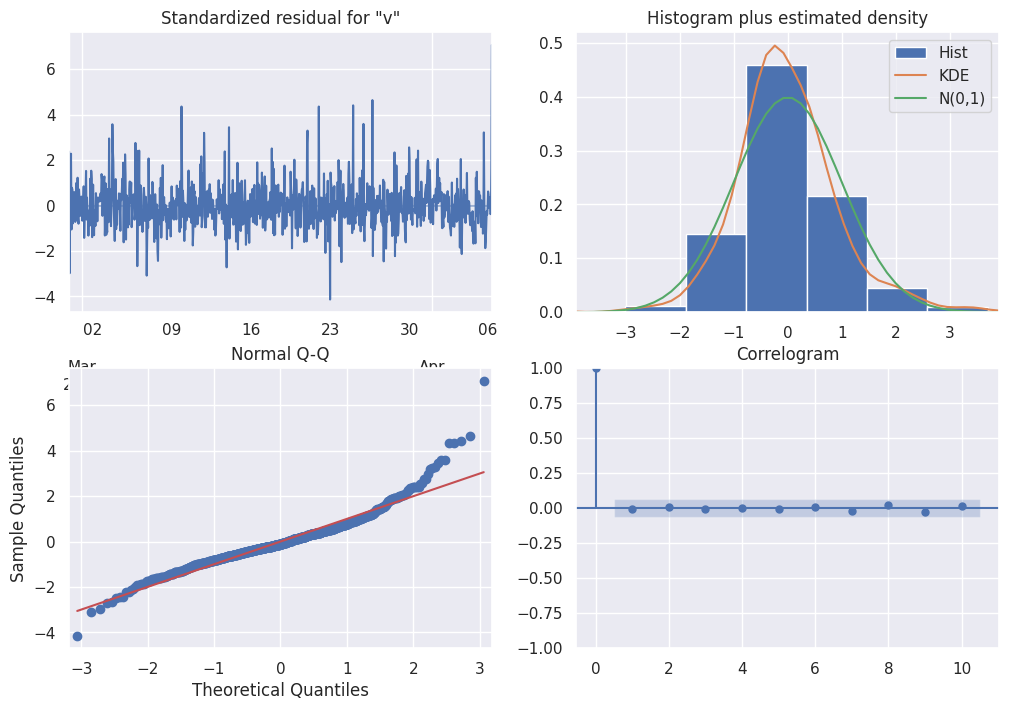

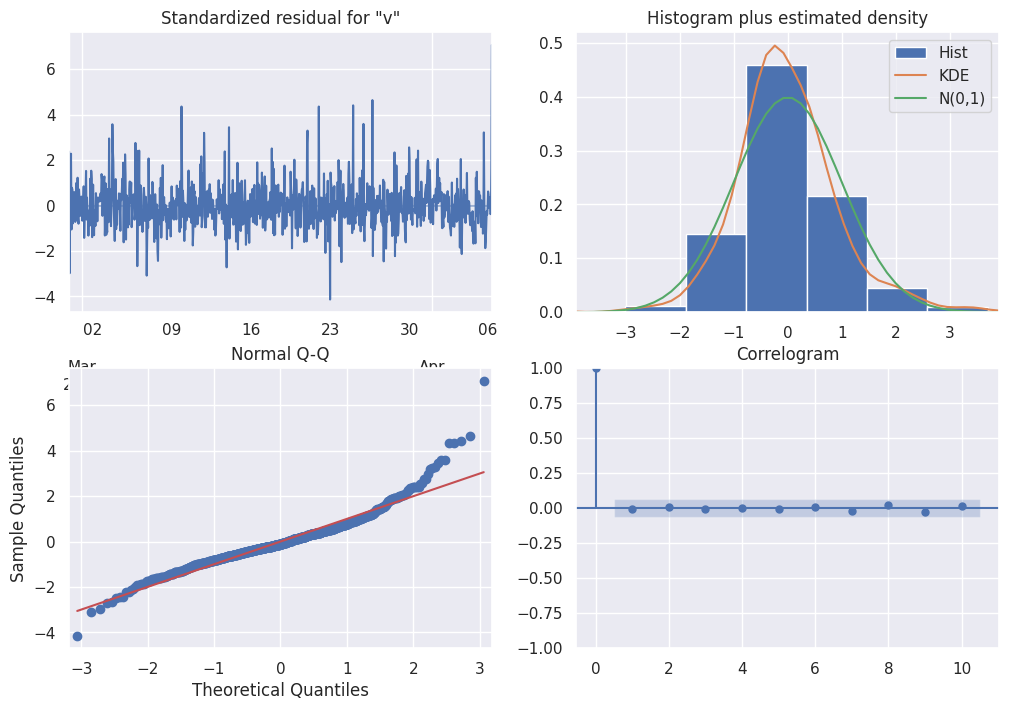

In [70]:
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8))

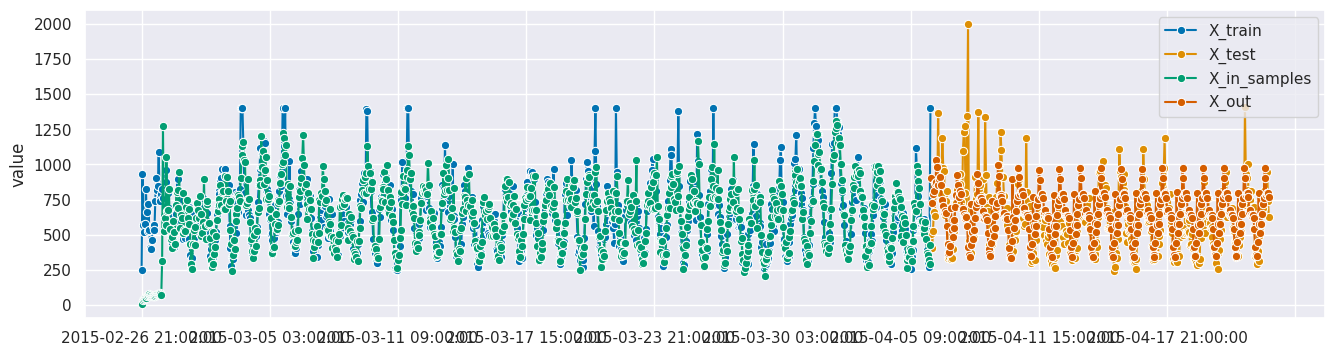

In [71]:
fhin = ForecastingHorizon(X_train.index[1:], is_relative=False)
X_in_samples = forecaster.predict(fhin)

X_out = forecaster.predict(FH)

plot_series(X_train, X_test, X_in_samples, X_out, labels=["X_train", "X_test", "X_in_samples", "X_out"])
plt.show()

In [72]:
smape(X_out.values, X_test.values)

0.22917836229842975

In [73]:
model = AutoARIMA(start_p=1,
                  d=1,
                  start_q=0,
                  max_p=5,
                  max_q=5,
                  seasonal=True,
                  start_P=0,
                  start_Q=0,
                  D=1,
                  sp=24,
                  max_order = 5,
                  trace  = True,
                  stepwise = True,
                  n_jobs = 1,
                  error_action='ignore',
                  suppress_warnings=True)

In [74]:
model.fit(X_train)

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,0)[24] intercept   : AIC=11961.010, Time=0.67 sec
 ARIMA(0,1,0)(0,1,0)[24] intercept   : AIC=12025.994, Time=0.24 sec
 ARIMA(1,1,0)(1,1,0)[24] intercept   : AIC=11713.312, Time=6.83 sec
 ARIMA(0,1,1)(0,1,1)[24] intercept   : AIC=inf, Time=9.63 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=12024.001, Time=0.24 sec
 ARIMA(1,1,0)(2,1,0)[24] intercept   : AIC=11634.883, Time=17.01 sec
 ARIMA(1,1,0)(2,1,1)[24] intercept   : AIC=inf, Time=42.40 sec
 ARIMA(1,1,0)(1,1,1)[24] intercept   : AIC=inf, Time=15.54 sec
 ARIMA(0,1,0)(2,1,0)[24] intercept   : AIC=11697.648, Time=15.60 sec
 ARIMA(2,1,0)(2,1,0)[24] intercept   : AIC=11568.681, Time=20.10 sec
 ARIMA(2,1,0)(1,1,0)[24] intercept   : AIC=11646.062, Time=9.75 sec
 ARIMA(2,1,0)(2,1,1)[24] intercept   : AIC=inf, Time=52.09 sec
 ARIMA(2,1,0)(1,1,1)[24] intercept   : AIC=inf, Time=21.19 sec
 ARIMA(3,1,0)(2,1,0)[24] intercept   : AIC=11564.750, Time=22.42 sec
 ARIMA(3,1,0)(1,1,0)[24] in

AutoARIMA(D=1, d=1, error_action='ignore', sp=24, start_P=0, start_Q=0,
          start_p=1, start_q=0, suppress_warnings=True, trace=True)

In [75]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  924
Model:             SARIMAX(5, 1, 0)x(2, 1, 0, 24)   Log Likelihood               -5767.203
Date:                            Sun, 07 Jan 2024   AIC                          11550.406
Time:                                    15:04:51   BIC                          11588.817
Sample:                                02-26-2015   HQIC                         11565.080
                                     - 04-06-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3896      0.027    -14.216      0.000      -0.443      -0.336
ar.L2         -0.3569      0.037     -9.673      0.000      -0.429      -0.285
ar.L3         -0.1532      0.040     -3.787      0.000      -0.233      -0.074
ar.L4         -0.1496      0.035     -4.262      0.000      -0.218      -0.081
ar.L5         -0.0541      0.037     -1.469      0.142      -0.126       0.018
ar.S.L24      -0.6340      0.022    -29.198      0.000      -0.677      -0.591
ar.S.L48      -0.2907      0.027    -10.966      0.000      -0.343      -0.239
sigma2      2.161e+04    592.139     36.501      0.000    2.05e+04    2.28e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               726.83
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.69
Prob(H) (two-sided):                  0.67   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

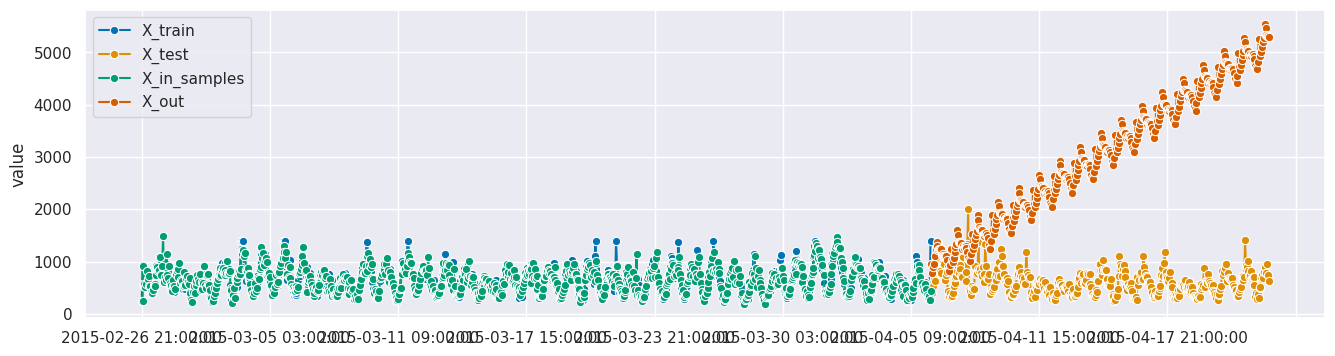

In [76]:
fhin = ForecastingHorizon(X_train.index[1:], is_relative=False)
X_in_samples = model.predict(fhin)

X_out = model.predict(FH)

plot_series(X_train, X_test, X_in_samples, X_out, labels=["X_train", "X_test", "X_in_samples", "X_out"])

In [77]:
smape(X_out.values, X_test.values)

1.2434372909717022

## 4.

## 5.

In [78]:
df = DF_ORIG.copy()

In [79]:
df['day_of_the_week'] = pd.to_datetime(df.index).weekday
df.sample(5)

,value,date,h,day_of_the_week
timestamp,,,,
2015-03-18 17:02:53,109,2015-03-18,17,2
2015-04-08 10:32:53,29,2015-04-08,10,2
2015-04-22 07:12:53,28,2015-04-22,7,2
2015-03-16 01:32:53,58,2015-03-16,1,0
2015-04-21 16:02:53,73,2015-04-21,16,1


In [80]:
def to_segments(df, column, size = 24):  
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)

In [81]:
working_week = to_segments(df[df['day_of_the_week'] <= 5], 'value', size = 24)
week_end = to_segments(df[df['day_of_the_week'] > 5], 'value', size = 24)

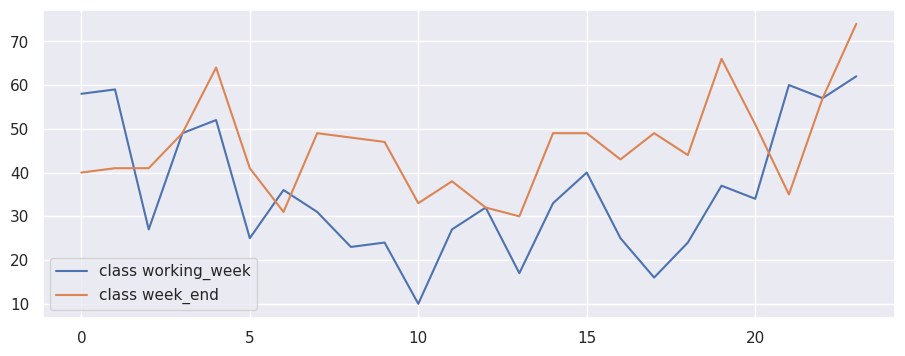

In [82]:
plt.figure()
day = 5
#for i,(c,d) in enumerate(zip([monday, tuesday, wednesday, turhday, friday, saturday, sunday],
#                             ['monday', 'tuesday', 'wednesday', 'turhday', 'friday', 'saturday', 'sunday'])):

for i,(c,d) in enumerate(zip([working_week, week_end],
                             ['working_week', 'week_end'])):
    plt.plot(c[day], label="class " + str(d))
plt.legend(loc="best")
plt.show()
plt.close()

In [83]:
X = np.concatenate((
                    working_week, 
                    week_end
                   ))
y = np.concatenate((
                    0*np.ones(working_week.shape[0]),
                    1*np.ones(week_end.shape[0]),
                   ))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(460, 24) (460,) (198, 24) (198,)


In [84]:
df_train = convert_to(np.atleast_3d(X_train).transpose(0,2,1), to_type="nested_univ")
df_test = convert_to(np.atleast_3d(X_test ).transpose(0,2,1), to_type="nested_univ")

In [85]:

clf = TimeSeriesForestClassifier(n_estimators=100,random_state=47)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f' test score TimeSeriesForestClassifier {test_score:.3f}')
table = pd.DataFrame([['TimeSeriesForestClassifier', test_score]], columns=['method', 'test_score'])

clf = RandomIntervalSpectralEnsemble(n_estimators=100, random_state=47)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f' test score RandomIntervalSpectralEnsemble {test_score:.3f}')
table2 = pd.DataFrame([['RandomIntervalSpectralEnsemble', test_score]], columns=['method', 'test_score'])
table = pd.concat([table, table2])

clf = SupervisedTimeSeriesForest(n_estimators=100, random_state=47)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f' test score SupervisedTimeSeriesForest {test_score:.3f}')
table2 = pd.DataFrame([['SupervisedTimeSeriesForest', test_score]], columns=['method', 'test_score'])
table = pd.concat([table, table2])

 test score TimeSeriesForestClassifier 0.859
 test score RandomIntervalSpectralEnsemble 0.848
 test score SupervisedTimeSeriesForest 0.869


In [86]:



clf = ShapeletTransformClassifier(estimator=RandomForestClassifier(n_estimators=100),
                                  n_shapelet_samples=100,
                                  max_shapelets=100,
                                  batch_size=20)

clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f' test score ShapeletTransformClassifier {test_score:.3f}')
table2 = pd.DataFrame([['ShapeletTransformClassifier', test_score]], columns=['method', 'test_score'])
table = pd.concat([table, table2])

 test score ShapeletTransformClassifier 0.859


In [87]:
clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="ddtw")
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f' test score KNeighborsTimeSeriesClassifier {test_score:.3f}')
table2 = pd.DataFrame([['KNeighborsTimeSeriesClassifier', test_score]], columns=['method', 'test_score'])
table = pd.concat([table, table2])

 test score KNeighborsTimeSeriesClassifier 0.758


In [88]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f' test score RandomForestClassifier {test_score:.3f}')
table2 = pd.DataFrame([['RandomForestClassifier', test_score]], columns=['method', 'test_score'])
table = pd.concat([table, table2])

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f' test score KNeighborsClassifier {test_score:.3f}')
table2 = pd.DataFrame([['KNeighborsClassifier', test_score]], columns=['method', 'test_score'])
table = pd.concat([table, table2])

 test score RandomForestClassifier 0.864
 test score KNeighborsClassifier 0.823


In [89]:
table

,method,test_score
0,TimeSeriesForestClassifier,0.858586
0,RandomIntervalSpectralEnsemble,0.848485
0,SupervisedTimeSeriesForest,0.868687
0,ShapeletTransformClassifier,0.858586
0,KNeighborsTimeSeriesClassifier,0.757576
0,RandomForestClassifier,0.863636
0,KNeighborsClassifier,0.823232


In [90]:
computer_setup()

os              : Linux-5.15.133+-x86_64-with-glibc2.35
python          : 3.10.12
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
torch           : 2.0.0
device          : 1 gpu (['Tesla P100-PCIE-16GB'])
cpu cores       : 2
threads per cpu : 2
RAM             : 31.36 GB
GPU memory      : [16.0] GB


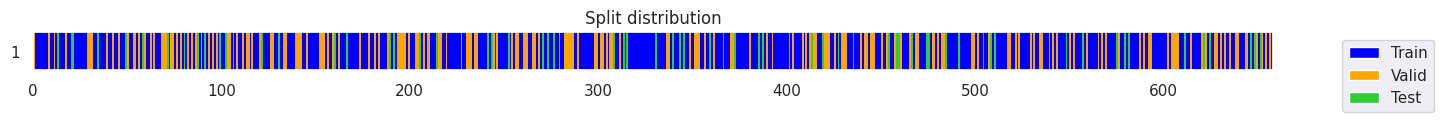

((#396) [132,558,52,198,493,438,494,146,402,22...],
 (#197) [219,262,453,457,289,234,630,45,197,39...],
 (#65) [359,435,34,646,372,504,475,91,160,214...])

In [91]:
splits = get_splits(y, 
                    n_splits=1, 
                    valid_size=0.3, 
                    test_size=0.1, 
                    shuffle=True, 
                    balance=False, 
                    stratify=True,
                    random_state=42, 
                    show_plot=True, 
                    verbose=True)
splits

In [92]:
X = np.atleast_3d(X.astype('float')).transpose(0,2,1)
y = y.astype('float')

print(X.shape, y.shape)
print (y)

(658, 1, 24) (658,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [93]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)

bs = 4
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

In [94]:
archs = [
         (RNNPlus, {'n_layers':3, 'bidirectional': True} ),
         (LSTMPlus,{'n_layers':3, 'bidirectional': True} ),
         (GRUPlus, {'n_layers':3, 'bidirectional': True} ),   
         (RNNPlus, {'n_layers':4, 'bidirectional': True} ),
         (RNNPlus, {'n_layers':4, 'bidirectional': False}),  
         (LSTM,    {'n_layers':3, 'bidirectional': False}), 
         (RNN,     {'n_layers':3, 'bidirectional': True} ), 
         (LSTM,    {'n_layers':3, 'bidirectional': True} ),
         (GRU,     {'n_layers':3, 'bidirectional': True} ),   
         (ResNet, {}), 
         (InceptionTime, {}), 
         (XceptionTime,  {}), 
         (TCN, {}),   
         (LSTM_FCN, {}), 
         (TST, {}),
         (FCN, {}),   
        ]

In [95]:
results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])

for i, (arch, k) in enumerate(archs):
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(20, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,LSTMPlus,"{'n_layers': 3, 'bidirectional': True}",566002,0.361827,0.361345,0.852792,19
1,GRUPlus,"{'n_layers': 3, 'bidirectional': True}",424602,0.339991,0.369582,0.852792,19
2,RNNPlus,"{'n_layers': 4, 'bidirectional': True}",202202,0.415612,0.410993,0.852792,22
3,LSTM,"{'n_layers': 3, 'bidirectional': False}",203002,0.311131,0.378982,0.852792,14
4,LSTM,"{'n_layers': 3, 'bidirectional': True}",566002,0.337741,0.363228,0.852792,19
5,GRU,"{'n_layers': 3, 'bidirectional': True}",424602,0.332125,0.367948,0.852792,18
6,TCN,{},66702,0.367074,0.389926,0.852792,42
7,RNNPlus,"{'n_layers': 3, 'bidirectional': True}",141802,0.387428,0.414174,0.847716,18
8,RNN,"{'n_layers': 3, 'bidirectional': True}",141802,0.409919,0.421302,0.847716,19
9,LSTM_FCN,{},314922,0.326167,0.403980,0.847716,18


In [96]:
arch = LSTM_FCN
k = {}
model = create_model(arch, dls=dls, **k)
model = build_ts_model(arch, arch_config=k, dls=dls)

SuggestedLRs(valley=0.0008317637839354575)

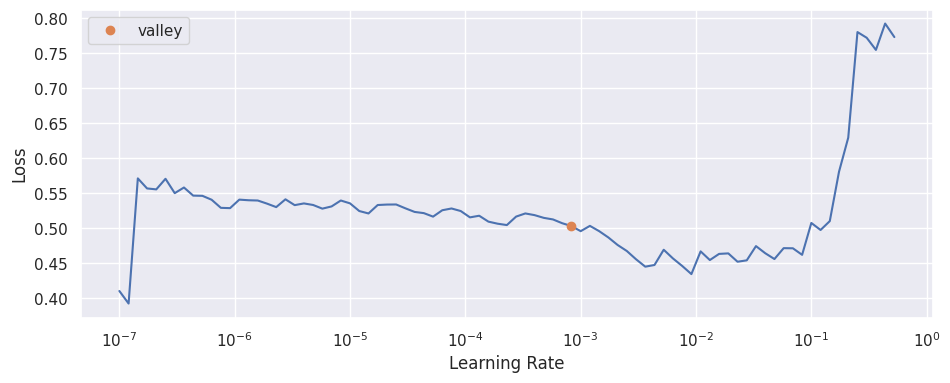

In [97]:
learn = ts_learner(dls, arch=model, metrics=accuracy) 
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.424163,0.400800,0.852792,00:00
1,0.407697,0.414411,0.852792,00:00
2,0.356620,0.394517,0.847716,00:00
3,0.376412,0.473624,0.842640,00:00
4,0.390795,0.388096,0.847716,00:00
5,0.399944,0.408925,0.842640,00:00
6,0.430256,0.441777,0.842640,00:00
7,0.408942,0.393979,0.847716,00:00
8,0.381296,0.413348,0.852792,00:00
9,0.390002,0.408170,0.852792,00:00


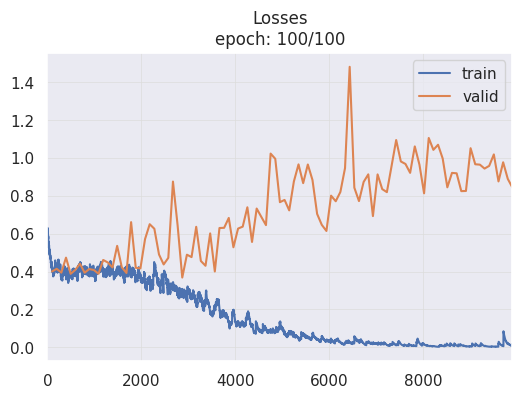

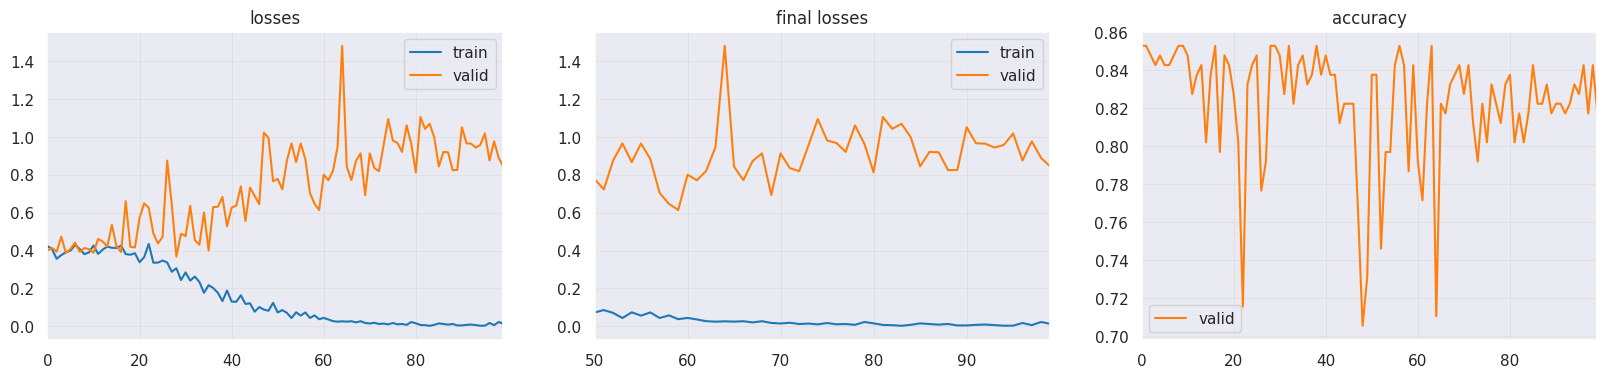

In [98]:
learn = Learner(dls, model,  metrics=accuracy)
start = time.time()
learn.fit_one_cycle(n_epoch = 100, lr_max = 0.0036, cbs=ShowGraph())

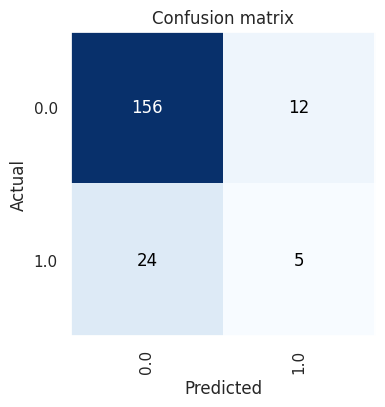

In [99]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [100]:
probas, _, preds = learn.get_X_preds(X[splits[2]])

print(y[splits[2]])
print(probas)

accuracy_score(np.argmax(probas,axis=-1),y[splits[2]])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
tensor([[9.9316e-01, 6.8370e-03],
        [7.8286e-01, 2.1714e-01],
        [8.3097e-01, 1.6903e-01],
        [9.9890e-01, 1.1007e-03],
        [9.9921e-01, 7.8955e-04],
        [1.0000e+00, 6.1175e-08],
        [9.9143e-01, 8.5672e-03],
        [1.0000e+00, 3.0107e-06],
        [1.0000e+00, 2.8409e-07],
        [9.9975e-01, 2.4795e-04],
        [9.9178e-01, 8.2245e-03],
        [9.9967e-01, 3.3252e-04],
        [9.9354e-01, 6.4576e-03],
        [9.9985e-01, 1.5158e-04],
        [1.0000e+00, 1.1526e-06],
        [9.9852e-01, 1.4791e-03],
        [9.9732e-01, 2.6779e-03],
        [1.0000e+00, 2.8774e-09],
        [9.9999e-01, 1.3786e-05],
        [9.9952e-01, 4.7935e-04],
        [8.4807e-01, 1.5193e-01],
        [9.9921e-01, 7.8892e-04],
        [9.9957e-01, 4.3059e-04],
        [9.9956e-01

0.8153846153846154

## 7. Anomalies check

In [101]:
df = df.drop(['h', 'day_of_the_week'], axis=1)

In [102]:
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(df)
anomalies.values.sum()

315

In [103]:
df2 = df.copy()
df2['a'] = anomalies['value']
df_a = df2[df2['a'] == True].copy()

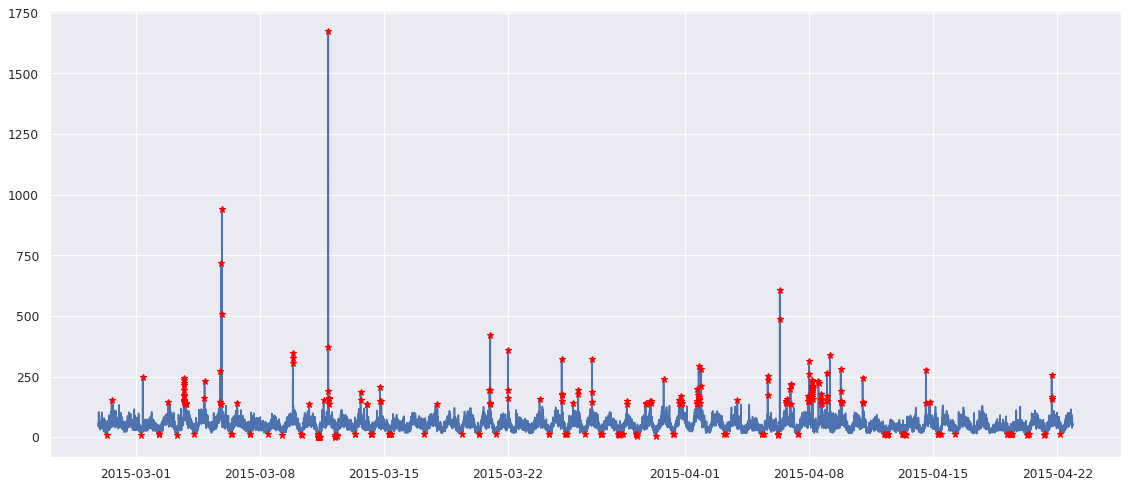

In [104]:
plt.figure(figsize=(14, 6), dpi=80, layout='constrained')
plt.plot(df.value)
plt.plot(df_a.value, color='red', marker='*', linestyle='', label = "anomalies")
plt.show()

In [105]:
seasonal_vol = SeasonalAD()
anomalies = seasonal_vol.fit_detect(df.value)

In [106]:
df2 = df.copy()
df2['a'] = anomalies
df_a = df2[df2['a'] == True].copy()

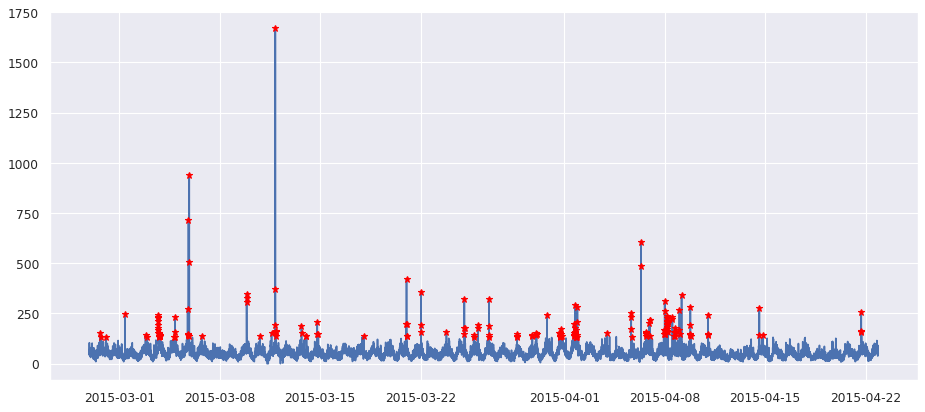

In [107]:
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(df.value)
plt.plot(df_a.value, color='red', marker='*', linestyle='',)
plt.show()

In [108]:
y = df.value.values.reshape(-1, 1)

In [109]:
model=DBSCAN(eps = 100., min_samples = 5)

In [110]:
model.fit(y)
colors = model.labels_
cls,counts = np.unique(colors, return_counts=True)
sort_idx = np.argsort(counts)

In [111]:
df2 = df.copy()
df2['a'] = colors
df_a = df2[df2['a'] == -1].copy()

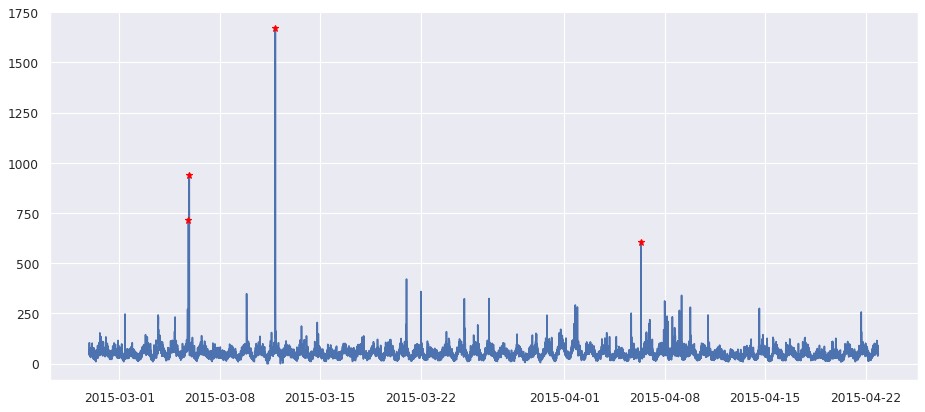

In [112]:
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(df.value)
plt.plot(df_a.value, color='red', marker='*', linestyle='',)
plt.show()